# Chapter 7. Nonlinear Featurization via K-Means Model Stacking

In [1]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn import manifold, datasets

In [2]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import seaborn as sns
%matplotlib notebook

## Swiss Roll

In [3]:
tt0 = 3 * np.pi / 2 * (1 + 2 * np.arange(0, 1.25, 0.01))
hh = np.arange(0, 1.125, 0.125) * 30
xx = np.transpose(np.tile(np.multiply(tt0, np.cos(tt0)), (len(hh), 1)))
yy = np.tile(hh, (len(tt0), 1))
zz = np.transpose(np.tile(np.multiply(tt0, np.sin(tt0)), (len(hh), 1)))
cc = np.transpose(np.tile((tt0-tt0.min())/(tt0.max()-tt0.min()), (len(hh), 1)))

<IPython.core.display.Javascript object>


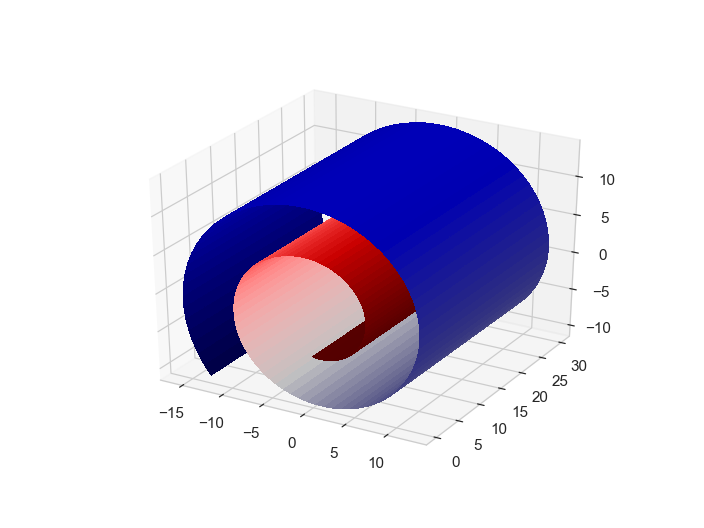

In [4]:
# 그림 7-1
sns.set_style('whitegrid')
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(xx, yy, zz, rstride=1, cstride=1, 
                linewidth=0, antialiased=False, 
                facecolors=cm.seismic_r(cc))

## Example 7-1. Code to generate k-means examples

In [5]:
n_data = 1000
seed = 1
n_centers = 4

# 무작위 가우시안 분포로 데이터 생성 및 k-means 실행
blobs, blob_labels = make_blobs(n_samples=n_data, n_features=2, 
                                centers=n_centers, random_state=seed)

clusters_blob = KMeans(n_clusters=n_centers, random_state=seed).fit_predict(blobs)

# 무작위 균일 분포로 데이터 생성 및 k-means 실행
uniform = np.random.rand(n_data, 2)

clusters_uniform = KMeans(n_clusters=n_centers, random_state=seed).fit_predict(uniform)

<IPython.core.display.Javascript object>


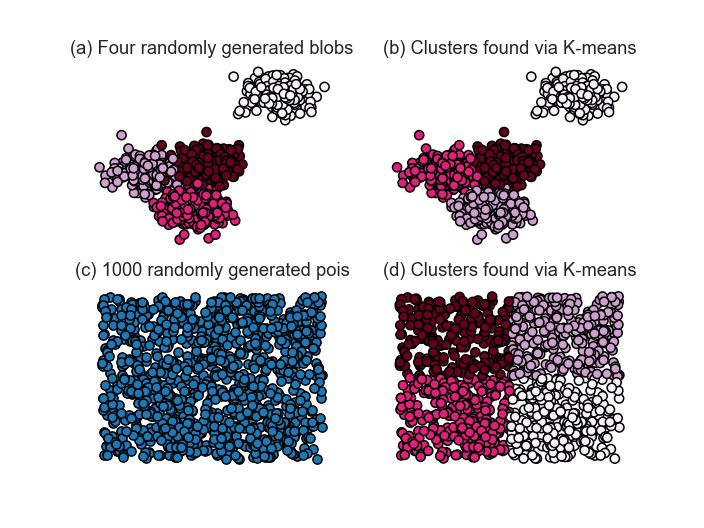

(-0.05898333299652795,
 1.0620597609403264,
 -0.06927705170583642,
 1.0675201127717653)

In [6]:
# 그림 7-2
figure = plt.figure()
plt.subplot(221)
plt.scatter(blobs[:, 0], blobs[:, 1], c=blob_labels, edgecolors='k', cmap='PuRd')
plt.title("(a) Four randomly generated blobs", fontsize=12)
plt.axis('off')

plt.subplot(222)
plt.scatter(blobs[:, 0], blobs[:, 1], c=clusters_blob, edgecolors='k', cmap='PuRd')
plt.title("(b) Clusters found via K-means", fontsize=12)
plt.axis('off')

plt.subplot(223)
plt.scatter(uniform[:, 0], uniform[:, 1], edgecolors='k')
plt.title("(c) 1000 randomly generated pois", fontsize=12)
plt.axis('off')

plt.subplot(224)
plt.scatter(uniform[:, 0], uniform[:, 1], c=clusters_uniform, edgecolors='k', cmap='PuRd')
plt.title("(d) Clusters found via K-means", fontsize=12)
plt.axis('off')

## Example 7-2. k-means on the Swiss roll

In [7]:
# 스위스롤 데이터셋 생성
X, color = datasets.samples_generator.make_swiss_roll(n_samples=1500)

In [8]:
# 100개의 k-means 클러스터로 데이터를 근사 계산
clusters_swiss_roll = KMeans(n_clusters=100, random_state=seed).fit_predict(X)

<IPython.core.display.Javascript object>


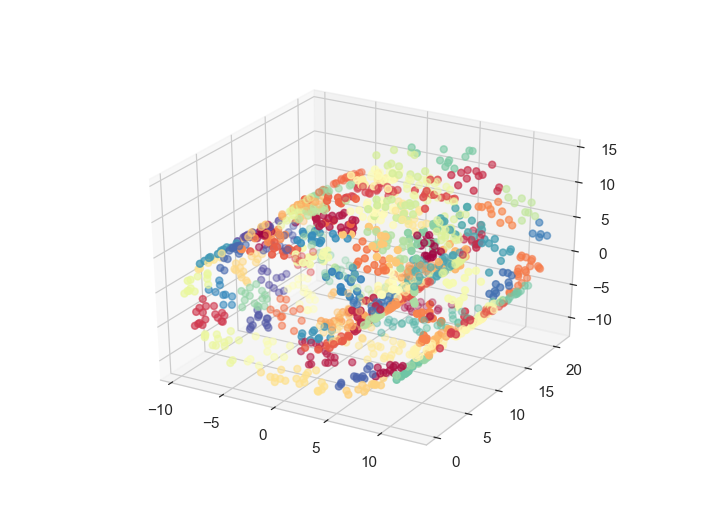

In [9]:
# 그림 7-4
fig2 = plt.figure()
ax = fig2.add_subplot(111, projection='3d')
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=clusters_swiss_roll, cmap='Spectral')

## Example 7-3. k-means featurizer

In [10]:
class KMeansFeaturizer:
    """Transforms numeric data into k-means cluster memberships.
    
    This transformer runs k-means on the input data and converts each data point
    into the id of the closest cluster. If a target variable is present, it is 
    scaled and included as input to k-means in order to derive clusters that
    obey the classification boundary as well as group similar points together.

    Parameters
    ----------
    k: integer, optional, default 100
        The number of clusters to group data into.

    target_scale: float, [0, infty], optional, default 5.0
        The scaling factor for the target variable. Set this to zero to ignore
        the target. For classification problems, larger `target_scale` values 
        will produce clusters that better respect the class boundary.

    random_state : integer or numpy.RandomState, optional
        This is passed to k-means as the generator used to initialize the 
        kmeans centers. If an integer is given, it fixes the seed. Defaults to 
        the global numpy random number generator.

    Attributes
    ----------
    cluster_centers_ : array, [k, n_features]
        Coordinates of cluster centers. n_features does count the target column.
    """

    def __init__(self, k=100, target_scale=5.0, random_state=None):
        self.k = k
        self.target_scale = target_scale
        self.random_state = random_state
        self.cluster_encoder = OneHotEncoder().fit(np.array(range(k)).reshape(-1,1))
        
    def fit(self, X, y=None):
        """Runs k-means on the input data and find centroids.

        If no target is given (`y` is None) then run vanilla k-means on input `X`. 

        If target `y` is given, then include the target (weighted by `target_scale`) 
        as an extra dimension for k-means clustering. In this case, run k-means 
        twice, first with the target, then an extra iteration without.

        After fitting, the attribute `cluster_centers_` are set to the k-means
        centroids in the input space represented by `X`.

        Parameters
        ----------
        X : array-like or sparse matrix, shape=(n_data_points, n_features)

        y : vector of length n_data_points, optional, default None
            If provided, will be weighted with `target_scale` and included in 
            k-means clustering as hint.
        """
        if y is None:
            # No target variable, just do plain k-means
            km_model = KMeans(n_clusters=self.k, 
                              n_init=20, 
                              random_state=self.random_state)
            km_model.fit(X)

            self.km_model_ = km_model
            self.cluster_centers_ = km_model.cluster_centers_
            return self

        # There is target information. Apply appropriate scaling and include
        # into input data to k-means            
        data_with_target = np.hstack((X, y[:,np.newaxis]*self.target_scale))

        # Build a pre-training k-means model on data and target
        km_model_pretrain = KMeans(n_clusters=self.k, 
                                   n_init=20, 
                                   random_state=self.random_state)
        km_model_pretrain.fit(data_with_target)

        # Run k-means a second time to get the clusters in the original space
        # without target info. Initialize using centroids found in pre-training.
        # Go through a single iteration of cluster assignment and centroid 
        # recomputation.
        km_model = KMeans(n_clusters=self.k, 
                          init=km_model_pretrain.cluster_centers_[:,:2], 
                          n_init=1, 
                          max_iter=1)
        km_model.fit(X)
        
        self.km_model = km_model
        self.cluster_centers_ = km_model.cluster_centers_
        return self
        
    def transform(self, X, y=None):
        """Outputs the closest cluster id for each input data point.

        Parameters
        ----------
        X : array-like or sparse matrix, shape=(n_data_points, n_features)

        y : vector of length n_data_points, optional, default None
            Target vector is ignored even if provided.

        Returns
        -------
        cluster_ids : array, shape[n_data_points,1]
        """
        clusters = self.km_model.predict(X)
        return self.cluster_encoder.transform(clusters.reshape(-1,1))
    
    def fit_transform(self, X, y=None):
        """Runs fit followed by transform.
        """
        self.fit(X, y)
        return self.transform(X, y)

## Example 7-4. k-means featurization with and without target hints

In [11]:
from scipy.spatial import Voronoi, voronoi_plot_2d
from sklearn.datasets import make_moons
from sklearn.preprocessing import OneHotEncoder
import scipy

In [12]:
seed = 1
training_data, training_labels = make_moons(n_samples=2000, noise=0.2, random_state=seed)

In [13]:
kmf_hint = KMeansFeaturizer(k=100, target_scale=10, random_state=seed).fit(training_data, training_labels)
kmf_no_hint = KMeansFeaturizer(k=100, target_scale=0, random_state=seed).fit(training_data, training_labels)

In [14]:
def kmeans_voronoi_plot(X, y, cluster_centers, ax):
    """Plots the Voronoi diagram of the kmeans clusters overlayed with the data"""
    ax.scatter(X[:, 0], X[:, 1], c=y, cmap='Set1', alpha=0.2)
    vor = Voronoi(cluster_centers)
    voronoi_plot_2d(vor, ax=ax, show_vertices=False, alpha=0.5)

<IPython.core.display.Javascript object>


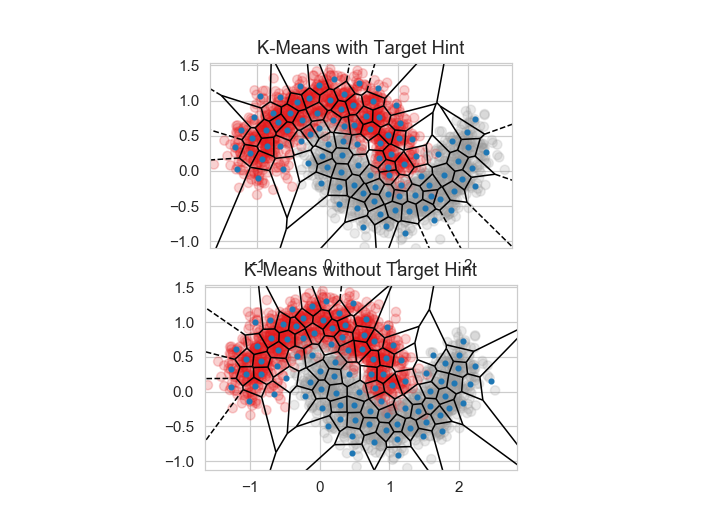

C:\Anaconda3\lib\site-packages\scipy\spatial\_plotutils.py:20: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  was_held = ax.ishold()


Text(0.5,1,'K-Means without Target Hint')

In [15]:
# 그림 7-6
fig = plt.figure()
ax = plt.subplot(211, aspect='equal')
kmeans_voronoi_plot(training_data, training_labels, kmf_hint.cluster_centers_, ax)
ax.set_title('K-Means with Target Hint')
ax2 = plt.subplot(212, aspect='equal')
kmeans_voronoi_plot(training_data, training_labels, kmf_no_hint.cluster_centers_, ax2)
ax2.set_title('K-Means without Target Hint')

## Example 7-5. Classification with k-means cluster features

In [16]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import roc_curve

In [17]:
# 트레이닝 데이터와 동일한 분포로 테스트 데이터 생성
test_data, test_labels = make_moons(n_samples=2000, noise=0.3, random_state=seed+5)

In [18]:
# 클러스터 피쳐를 생성하기 위해 k-means 피쳐 생성기 사용
training_cluster_features = kmf_hint.transform(training_data)
test_cluster_features = kmf_hint.transform(test_data)

# 클러스터 피쳐로 새로운 입력 피쳐 구성
training_with_cluster = scipy.sparse.hstack((training_data, training_cluster_features))
test_with_cluster = scipy.sparse.hstack((test_data, test_cluster_features))

In [19]:
lr_cluster = LogisticRegression(random_state=seed).fit(training_with_cluster, training_labels)

classifier_names = ['LR',
                    'kNN',
                    'RBF SVM',
                    'Random Forest',
                    'Boosted Trees']
classifiers = [LogisticRegression(random_state=seed),
               KNeighborsClassifier(5),
               SVC(gamma=2, C=1, random_state=seed),
               RandomForestClassifier(max_depth=5, n_estimators=10, 
                                      max_features=1, random_state=seed),
               GradientBoostingClassifier(n_estimators=10, learning_rate=1.0,
                                          max_depth=5, random_state=seed)]
for model in classifiers:
    model.fit(training_data, training_labels)

In [20]:
# ROC를 사용해 분류기의 성능을 평가하는 헬퍼 함수
def test_roc(model, data, labels):
    if hasattr(model, "decision_function"):
        predictions = model.decision_function(data)
    else:
        predictions = model.predict_proba(data)[:,1]
    fpr, tpr, _ = roc_curve(labels, predictions)
    return fpr, tpr

<IPython.core.display.Javascript object>


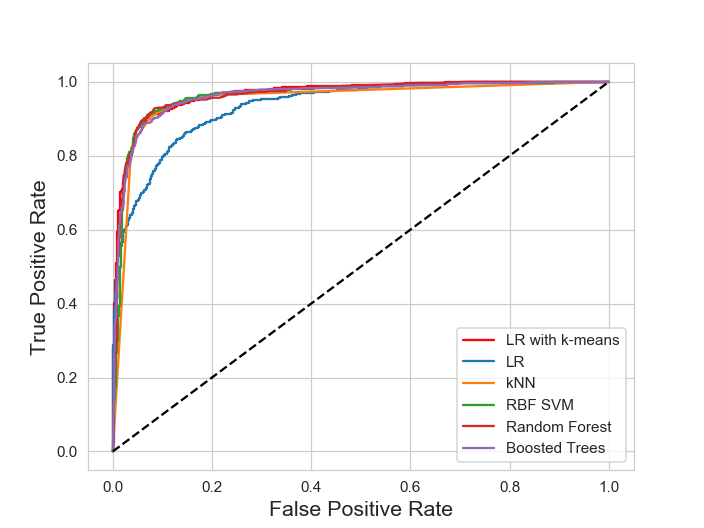

Text(0,0.5,'True Positive Rate')

In [21]:
# 그림 7-7
plt.figure()
fpr_cluster, tpr_cluster = test_roc(lr_cluster, test_with_cluster, test_labels)
plt.plot(fpr_cluster, tpr_cluster, 'r-', label='LR with k-means')

for i, model in enumerate(classifiers):
    fpr, tpr = test_roc(model, test_data, test_labels)
    plt.plot(fpr, tpr, label=classifier_names[i])
    
plt.plot([0, 1], [0, 1], 'k--')
plt.legend()
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)

In [22]:
classifiers[2].dual_coef_.shape

(1, 216)